In [ ]:
from math import sin, cos, sqrt, pi, log, asin
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
from scipy.stats import norm, ttest_1samp
from scipy.stats import pearsonr

### Log Call

In [ ]:
def LinearCongruentialGenerator(a, c, N, seed):     
    I_0 = seed
    while True:
        I = (a * I_0 + c) % N
        I_0 = I
        yield I_0

def generate_sequence(n, seed=123456789,
                      a=1664525, c=1013904223, N=2**32):
    sample = []
    rng = LinearCongruentialGenerator(a, c, N, seed)
    for i in range(n):
        observation = next(rng) / (N-1)
        sample.append(observation)
    return np.array(sample)

In [ ]:
def BoxMuller(u1, u2):
    z1 = sqrt(- 2 * log(u1)) * cos(2 * pi * u2)
    z2 = sqrt(- 2 * log(u1)) * sin(2 * pi * u2)
    return z1, z2

def generate_norm_sequence(seq):
    out = []
    for i in range(0, len(seq), 2):
        u1 = seq[i]
        u2 = seq[i+1]
        box_muller = BoxMuller(u1, u2)
        out.append(box_muller[0])
        out.append(box_muller[1])
    return out

In [ ]:
unif_seq_1 = generate_sequence(1000)
norm_seq_1 = generate_norm_sequence(unif_seq_1)
z_ = norm_seq_1
discretisation = np.linspace(0.65*3200, 1.50*3200, 100)

In [76]:
def BS_CallDelta(K=3200, dt=1.0, s=0.215, r=0.0045, y=0.018):
    delta = []
    for S_0 in discretisation:
        x_plus = (np.log(S_0/K)+(r-y)) / s + s/2
        delta.append(exp(-y)*norm.cdf(x_plus))
    return delta

In [78]:
def BS_Call(S, K, sigma, r, y, t, T):    
    x_p = ( np.log(S/K) + (r - y) * (T-t) ) / (sigma * np.sqrt(T-t)) + sigma * np.sqrt(T-t) / 2
    x_m = ( np.log(S/K) + (r - y) * (T-t) ) / (sigma * np.sqrt(T-t)) - sigma * np.sqrt(T-t) / 2
    return S * np.exp(-y * (T-t)) * norm.cdf(x_p) - K * np.exp(-r * (T-t)) * norm.cdf(x_m)

In [81]:
def MC_LogCall(s, SSim, K=3200, r=0.0045,y=0.018,sigma=0.215, t=0,T=1):
    payoff = [K*max(np.log(S_T/K),0) - max(S_T-K,0) for S_T in SSim]
    values = [p*exp(-r*(T-t)) for p in payoff]
    bsCall = BS_Call(s, K, sigma,r,y,t,T)
    value =  np.mean(values) + bsCall
    std_err = sample_std(values)/sqrt(len(SSim))
    return value, std_err, values    

In [87]:
def CV_LogCall_delta(z, epsilon):
    delta = []
    for S_0 in discretisation:
        S_plus_values = [S_T(zi, S_0*(1+epsilon)) for zi in z]
        S_minus_values = [S_T(zi, S_0*(1-epsilon)) for zi in z]
        # difference of two options payoff
        LogCall_1 = MC_LogCall(S_0*(1-epsilon), S_minus_values)[0]
        LogCall_2 = MC_LogCall(S_0*(1+epsilon),S_plus_values)[0]
        delta.append((LogCall_2-LogCall_1)/(2*S_0*epsilon))
    return delta
def CV_LogCall_gamma(z, epsilon):
    gamma = []
    for S_0 in discretisation:
        S_0_values = [S_T(zi, S_0) for zi in z]
        S_plus_values = [S_T(zi, S_0*(1+epsilon)) for zi in z]
        S_minus_values = [S_T(zi, S_0*(1-epsilon)) for zi in z]
        
        LC_0 = MC_LogCall(S_0, S_0_values)[0]
        LC_1 = MC_LogCall(S_0*(1-epsilon), S_minus_values)[0]
        LC_2 = MC_LogCall(S_0*(1+epsilon),S_plus_values)[0]

        gamma.append((LC_2+LC_1-2*LC_0)/((S_0*epsilon)**2))
    return gamma  

epsilon=0.001


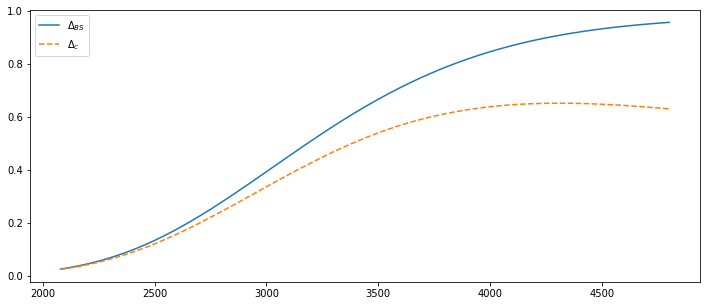

In [86]:
print("epsilon=0.001")
plt.figure(figsize=(12,5))
plt.plot(discretisation, BS_CallDelta(), label='$\Delta_{BS}$')
plt.plot(discretisation, CV_LogCall_delta(z_, 0.001), label='$\Delta_{c}$', linestyle="dashed")
plt.legend();

epsilon=0.001


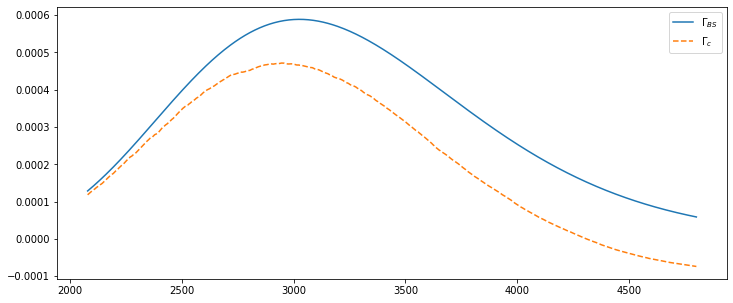

In [90]:
### Gamma
print("epsilon=0.001")
plt.figure(figsize=(12,5))
plt.plot(discretisation, BS_gamma(), label='$\Gamma_{BS}$')
plt.plot(discretisation, CV_LogCall_gamma(z_, 0.001), label='$\Gamma_{c}$', linestyle="dashed")
plt.legend();

#### Only slight quantization effects observed, thus Control Variate greatly reduces quantization effects as well